# PROJET D'OPTIMISATION
## Romain LAGARDE, Tom SCHIPPKE


-----------------------------------

PROBLEME DE CONVERGENCE DE LALGO EN FONCTION DES CONDITIONS INITIALES: POUR XO parfois solutions bizarres ou non optimales

-----------------------------------

## 1 Etude du problème d’optimisation



**1.** Sur un intervalle de temps $[t_i;t_{i+1}]$ le tarif d'électricité est supposé constant de valeur $c_i$. Ainsi l'énergie consommée sur cet intervalle de temps étant $(t_{i+1} - t_i)P_i = \Delta t P_i$, le prix a payer est alors $c_i \Delta t P_i$.

Au final, la fatcure totale est obtenue en sommant les factures sur les intervalles $[t_i;t_{i+1}]$ pour $i \in [0,n]$, donc **le prix total à payer est**: 

$$\sum_{i=0}^{n}{c_i \Delta t P_i}=\Delta t  \sum_{i=0}^{n}{c_i P_i}$$

**2.**
Cette équation d'évolution (discrétisée) de la température prend en compte les **échanges thermiques du bâtiment avec son environnement**.

Elle tient compte du fait que la température intérieure diminue avec le temps s'il n'y a pas de chauffage (premier terme de l'équation; l'argument de l'exponentielle est strictement négatif). Ensuite, elle ajoute l'effet du chauffage (deuxième terme de l'équation) et de la température extérieure.

 Cette modélisation semble **plutôt raisonnable** pour estimer en première approche l'évolution de la température moyenne du bâtiment.



**3.** L'objectif du problème est de **minimiser la facture** *(5)* de chaufage à payer en **respectant différentes contraintes**.

On considère que les variables $(T_i^e)_{i \in [1,N]}$ sont entièrement définies par une loi extérieure et ne dépendent pas de l'utilisateur. 

On considère ainsi les variables de décisions $$x=(P_0, T_0,...,P_i,T_i,...,P_{N}, T_{N})$$ au **nombre de $2(N+1)$**.

On pose de plus, afin de traduire la recherche de minimisation de la facture *(5)*,
$$f(x)=\Delta t  \sum_{i=0}^{N}{c_i P_i}$$
 afin de chercher à résoudre $\min\limits_{x \in\Re ^{2(N+1)}}{f(x)}$.

On traduit la contrainte de confort *(4)* et de puissance disponible *(1)* en posant: $$c_{in}(x)= \begin{pmatrix} P_0 - P_M \\ -P_0 \\...\\ P_i - P_M \\ -P_i \\... \\ P_N - P_M \\ -P_N \\ T_m - T_k \\  T_k - T_M \end{pmatrix}_{k \in I_{occ}}  \le 0$$


Enfin, on traduit l'évolution (discrétisée) de la température *(2)* et les conditions initiales *(3)*: $$c_{eq}(x)= \begin{pmatrix} e^{-(k+h) \Delta t} T_0 + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_0 +hT_0^e) - T_{1}  \\ ... \\  e^{-(k+h) \Delta t} T_i + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_i +hT_i^e) - T_{i+1} \\ ... \\ e^{-(k+h) \Delta t} T_{N-1} + \frac{1-e^{-(k+h) \Delta t}}{k+h}(bP_{N-1} +hT_{N-1}^e) - T_{N} \\ T_0 - T_{in} \\ P_N\end{pmatrix}  = 0$$



**4.**
D'une part **f est clairement convexe** *(17)*: $\nabla ^2 f(x)=0 \geq 0$.

D'autre part, comme par *(16)* chaque ligne de $c_{eq}$ est combinaison linéaire des $(P_i)_i$ et $(T_i)_i$ sommé à un terme constant, on peut écrire $c_{eq}(x) = Ax + B$.

Ainsi la contrainte égalité **$c_{eq}$ est affine** *(18)*.

Enfin **$c_{in}$ est convexe** *(19)* car $\forall i$ $h_i(x)=T_m - T_i$,  $g_i(x)=T_i- T_M$ ,  $u_i(x)=P_i - T_M$ et $z_i(x)=-P_i$ sont clairement convexes (combinaisons linéaires des $P_i$ et $T_i$ ).

Ainsi, par *(17), (18)* et *(19)*, le **problème étudié est convexe**. Il s'agit par ailleurs d'un **problème d'optimalité à contrainte égalité et inégalité**.

## 2 Etude et résolution numérique du problème individuel


**5.** Le problème étant convexe, il est possible d'utiliser le **théorème de Karush-Kuhn-Tucker (KKT)** pour trouver des potentielles solutions (les conditions nécessaires aux théorème sont aussi dans ce cas suffisantes). Cependant la complexité du problème semble poser problème pour cette méthode.

On pourrait aussi utiliser **l'algorithme d'Uzawa** pour résoudre le problème numériquement. Il est aussi possible d'utiliser la fonction **minimize** de la bibliothèque scipy.

**6.**

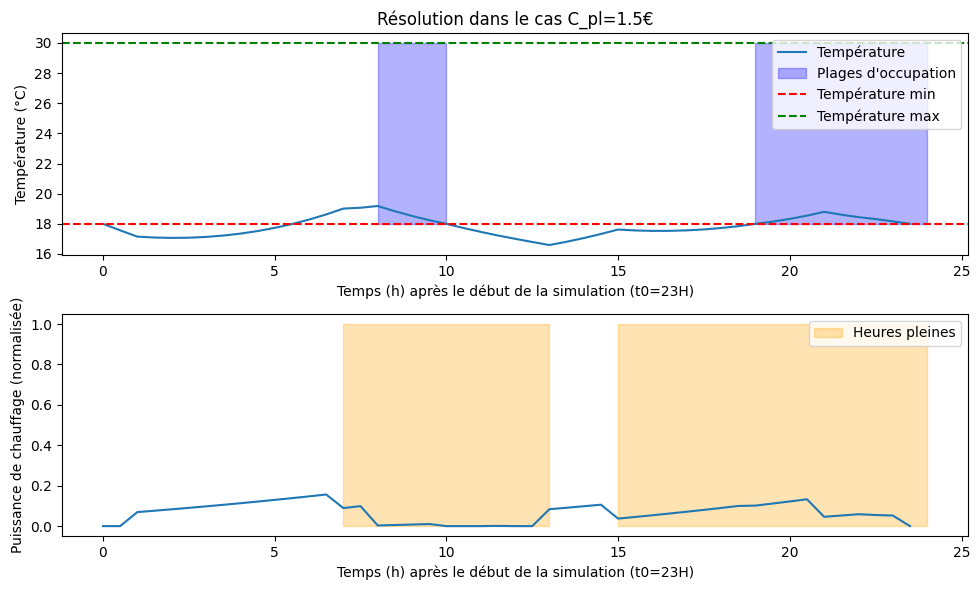

La facture à payer est:  9.853  €.
Le résultat fournit par l'algorithme de résolution est optimal.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#définition des constantes du problème
ccr=1
Tm=18  #températures exprimées en Kelvin
TM=30 
Tin=Tm
h=0.05
k=0.01
b=1/500
N=48
PM=5000
dt=0.5
t_0=23
C=[]


# Fonction température extérieure

def outside_temp(t):
    '''fonction renvoyant la température extérieur à une heure donnée'''
    return 4+8*np.exp((-(t-(24-t_0%24)-12)**2 )/40)   #le décalage temporel permet de tenir compte de la date initiale t_0

Te=outside_temp(np.array([i/2 for i in range (48)]))


# Contraintes
def contraintes_ineq(X):
    T = X[:N]
    P = X[N:]
    contraintes = []
    for i in range(N):
        if 7+(24-t_0) <= i/2 % 24 <= 9+(24-t_0) or 18+(24-t_0) <= i/2 % 24 <= 23+(24-t_0):
            # Contraintes de température pendant les heures d'occupation
            contraintes.append(T[i]-Tm)
            contraintes.append(TM-T[i] )
            
        # Contraintes de puissance de chauffage
        contraintes.append(P[i])
        contraintes.append(PM-P[i])

    return np.array(contraintes)



def contraintes_eq(X):
    T = X[:N]
    P = X[N:]
    contraintes = [T[0]-Tin, P[N-1]]
    for i in range(N-1):
        contraintes.append(np.exp(-(k+h)*dt)*T[i]+((1-np.exp(-(k+h)*dt))/(k+h))*(b*P[i]+h*Te[i])-T[i+1])
    return np.array(contraintes)

# Fonction objectif à minimiser
def cost(X):
    Power = X[N:]
    return dt*np.sum(np.array(Power)*C)*1e-3



def resolution (cpl=1.50):
    global C
    C=[]

    for i in range (48):
        t=i*dt
        if (0+(24-t_0)<=t and t<6+(24-t_0)) or (12+(24-t_0)<=t and t<14+(24-t_0)):
            C.append(ccr)
        else:
            C.append(cpl)
    C=np.array(C)


    # Initialisation des variables
    X0 = np.zeros(2 * N)
    X0[:N] = (TM+Tm)/2  # Température initiale
    #X0[0]=Tm

    # Définition des contraintes et de la fonction objectif pour minimize
    contraintes_dict = ({'type': 'eq', 'fun': contraintes_eq},{'type': 'ineq', 'fun': contraintes_ineq})

    # Résolution avec minimize
    resultat_minimize = minimize(cost, X0, constraints=contraintes_dict, options={'disp': False,'maxiter': 300})

    # Récupération des résultats
    T_resultat = resultat_minimize.x[:N]
    Pow_resultat = resultat_minimize.x[N:]

    
    # Affichage des résultats
    temps = np.arange(0, N/2, 0.5)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title('Résolution dans le cas C_pl={}€'.format(cpl))
    plt.plot(temps, T_resultat, label='Température')
    
    plt.fill_between([7+(24-t_0),9+(24-t_0)], Tm, TM, alpha=0.3, color='blue', label='Plages d\'occupation')
    plt.fill_between([18+(24-t_0),23+(24-t_0)], Tm, TM, alpha=0.3, color='blue')
    plt.axhline(y=Tm, color='r', linestyle='--', label='Température min')
    plt.axhline(y=TM, color='g', linestyle='--', label='Température max')
    plt.xlabel('Temps (h) après le début de la simulation (t0=23H)')
    plt.ylabel('Température (°C)')
    plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.plot(temps, Pow_resultat / PM)
    plt.xlabel('Temps (h) après le début de la simulation (t0=23H)')
    plt.ylabel('Puissance de chauffage (normalisée)')
    plt.fill_between([6+(24-t_0),12+(24-t_0)], 0, 1, alpha=0.3, color='orange', label='Heures pleines')
    plt.fill_between([14+(24-t_0),23+(24-t_0)], 0, 1, alpha=0.3, color='orange')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    print('La facture à payer est: ', round(cost(resultat_minimize.x), 3),' €.')
    if  resultat_minimize.success == True:
        print('Le résultat fournit par l\'algorithme de résolution est optimal.')
    else:
        if resultat_minimize.message == 'Iteration limit reached':
            print('Le résultat fournit par l\'algorithme de résolution n\'est pas optimal car le nombre d\'itération mamimum a été atteint.')
        else: 
            print('Le résultat fournit par l\'algorithme de résolution n\'est pas optimal car: ', resultat_minimize.message)
    return

resolution()

L'algorithme de résolution du problème permet ainsi d'optimiser le réglage de puissance de chauffage afin de minimiser le prix à payer. Ainsi, on se rend compte que globalement, il convient d'automatiser le **chauffage** afin que ce dernier se fasse (en majorité) **lors de plage horaire de non présence**.







**7.**

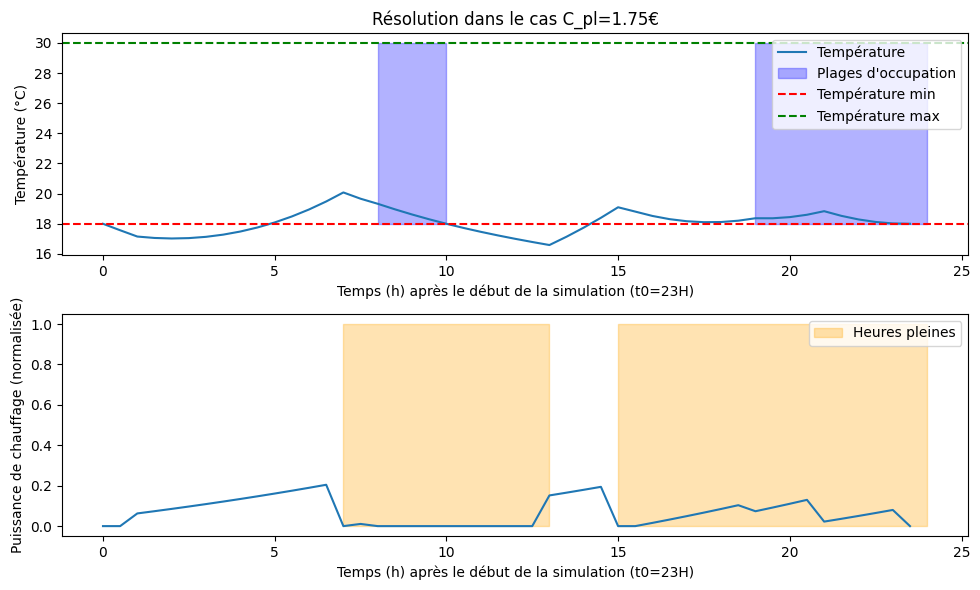

La facture à payer est:  10.112  €.
Le résultat fournit par l'algorithme de résolution est optimal.


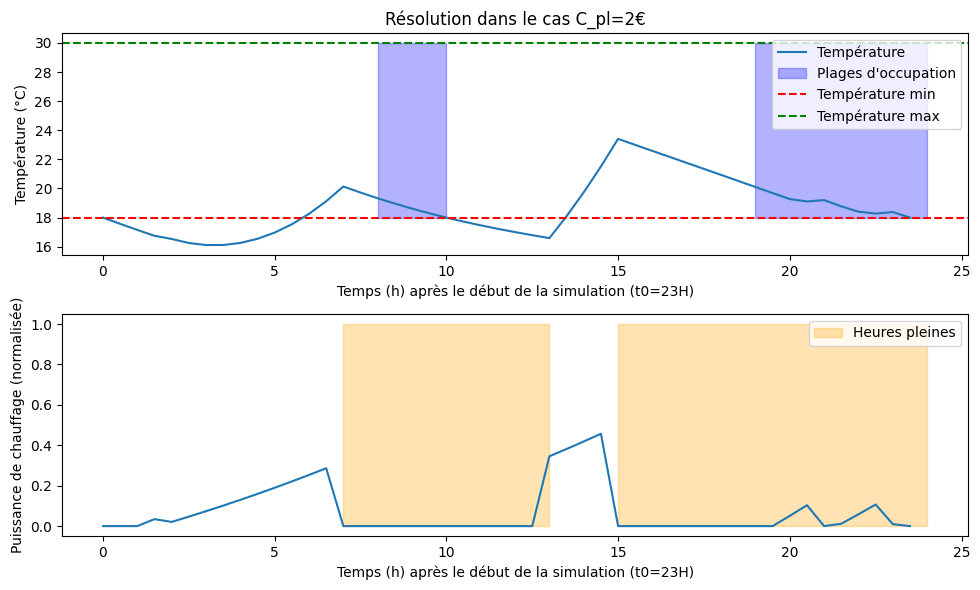

La facture à payer est:  9.509  €.
Le résultat fournit par l'algorithme de résolution est optimal.


In [25]:
#On reprend l'algorithme de résolution précédent
resolution(cpl=7/4)
resolution(cpl=2)

On se rend compte que le **prix à un effet incitatif sur la façon de consommer**: augmenter  le prix de l'énergie en heure pleine change le comportement optimal: plus le prix est élévé en heure pleine, plus le chauffage optimal se base sur un chauffage en heure creuse. Ainsi, augmenter le prix de l'énergie en heure pleine (ou baisser celui en heure creuse) permettrait de désengorger les heures pleines et ainsi potentiellement éviter les pics de consommation.

## 3 Régulation collective



**8.** On considère les nouvelles **variables de décisions** $x=(P_i^j, T_i^j)_{(i,j) \in [0,N] \times [1,n_l]}$.

La fonction à minimiser devient alors $$f(x)=\Delta t  \sum_{i=0}^{N}{\sum_{j=1}^{n_l}{c_i P_i^j}}$$
 afin de chercher à résoudre $\min\limits_{x \in\Re ^{2(N+1)n_l}}{f(x)}$.

On a désormais la contrainte inégalité:
 
$$c_{in}(x)= \begin{pmatrix}  T_i^j - T_M \\ T_m-T_i^j \\ P_k^j - P_M \\ -P_k^j  \end{pmatrix}_{(k,j) \in  [1,N] \times [1,n_l], i \in I_{occ}^j}  \le 0$$

 $$c_{eq}(x)= \begin{pmatrix} e^{-(k+h + \sum_{k\neq j}{h_{jk}}) \Delta t} T_i^j + \frac{1-e^{-(k+h+\sum_{k\neq j}{h_{jk}}) \Delta t}}{k+h+\sum_{k\neq j}{h_{jk}}}(bP_i^j +hT_i^{e} +\sum_{k\neq j}{h_{jk} T_i^{k}}) - T_{i+1}^j  \\ T_0^j - T_{in}^j \\ P_N^j\end{pmatrix}_{(i,j) \in [0,N] \times [1,n_l]}  = 0$$

**9.** On regroupe les avantages et désavantages dans la suite:

**Désavantages:**

-**connaitre les heures de présence** de tout le monde.

   -mesure non intéressante si tout les **locataires n'ont pas les mêmes horaires de vie**: si quelqu'un est absent toute la journée: le chauvage risque d'être activé chez lui pour limiter les pertes thermiques des appartements adjacents et le personne absente payera donc une facture

**Avantages:**

-permet d'avoir un appercu global de tout les logements et de **faire encore plus d'économie d'énergie** en evitant les transferts thermiques entre logement.
    
   -cette modélisation est **plus réaliste**.

**10.**



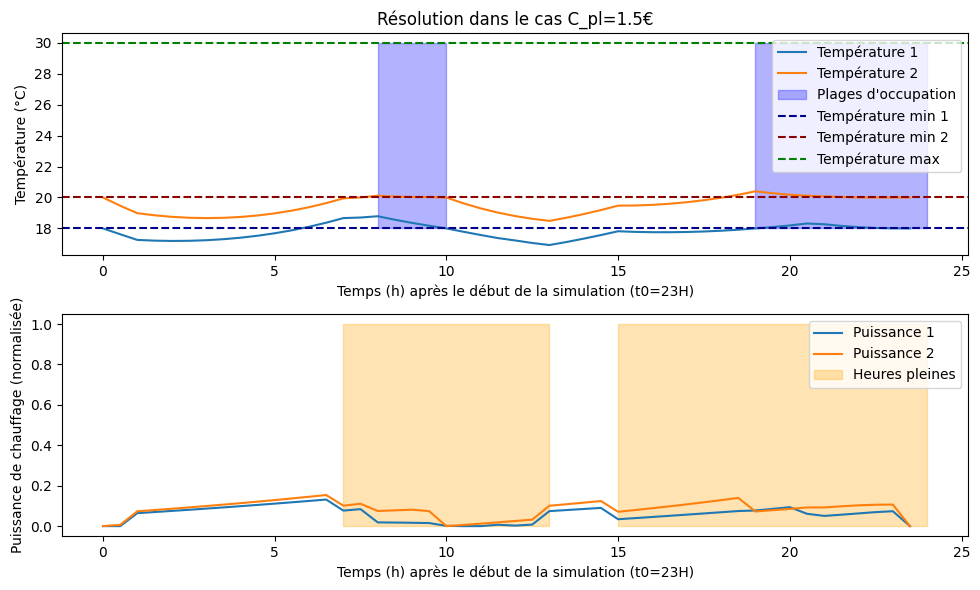

La facture à payer est:  21.665  €.
Le résultat fournit n'est pas optimal car le nombre d'itération mamimum a été atteint.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#définition des constantes du problème
ccr=1
Tm1=18  #températures exprimées en degrès C
Tm2=20
TM=30 
Tin1=Tm1
Tin2=Tm2
h=0.05
k=0.01
b=1/500
N=48
PM=5000
dt=0.5
t_0=23
C=[]


# Fonction température extérieure

def outside_temp(t):
    '''fonction renvoyant la température extérieur à une heure donnée'''
    return 4+8*np.exp((-(t-(24-t_0%24)-12)**2 )/40)  #le décalage temporel permet de tenir compte de la date initiale t_0


Te=outside_temp(np.array([i/2 for i in range (48)]))

# Contraintes
def contraintes_ineq(X):
    T1 = X[:N]
    T2 = X[N:2*N]
    P1 = X[2*N:3*N]
    P2 = X[3*N:]
    contraintes = []
    for i in range(N):
        if 7+(24-t_0)<= i/2 % 24 <= 9+(24-t_0) or 18+(24-t_0) <= i/2 % 24 <= 23+(24-t_0):
            # Contraintes de température pendant les heures d'occupation
            contraintes.append(T1[i]-Tm1)
            contraintes.append(TM-T1[i] )
            
        # Contraintes de puissance de chauffage
        contraintes.append(P1[i])
        contraintes.append(PM-P1[i])
    for i in range(N):
        if 7+(24-t_0) <= i/2 % 24 <= 9+(24-t_0) or 18+(24-t_0) <= i/2 % 24 <= 23+(24-t_0):
            # Contraintes de température pendant les heures d'occupation
            contraintes.append(T2[i]-Tm2)
            contraintes.append(TM-T2[i] )
            
        # Contraintes de puissance de chauffage
        contraintes.append(P2[i])
        contraintes.append(PM-P2[i])

    return np.array(contraintes)



def contraintes_eq(X):
    T1 = X[:N]
    T2 = X[N:2*N]
    P1 = X[2*N:3*N]
    P2 = X[3*N:]
    #contrainte du 1er logement
    contraintes = [T1[0]-Tin1, P1[N-1]]
    for i in range(N-1):
        contraintes.append(np.exp(-(k+h+h)*dt)*T1[i]+((1-np.exp(-(k+h+h)*dt))/(k+h+h))*(b*P1[i]+h*Te[i]+h*T2[i])-T1[i+1])
    #contrainte du 2eme logement

    contraintes.append(T2[0]-Tin2)
    contraintes.append( P2[N-1])
    for i in range(N-1):
        contraintes.append(np.exp(-(k+h+h)*dt)*T2[i]+((1-np.exp(-(k+h+h)*dt))/(k+h+h))*(b*P2[i]+h*Te[i]+h*T1[i])-T2[i+1])
    return np.array(contraintes)

# Fonction objectif à minimiser
def cost(X):
    Power1 = X[2*N:3*N]
    Power2 = X[3*N:]
    return dt*np.sum(np.array(Power1)*C)*1e-3 + dt*np.sum(np.array(Power2)*C)*1e-3



def resolution (cpl=1.50):
    global C
    C=[]

    for i in range (48):
        t=i*dt
        if (0+(24-t_0)<=t and t<6+(24-t_0)) or (12+(24-t_0)<=t and t<14+(24-t_0)):
            C.append(ccr)
        else:
            C.append(cpl)
    C=np.array(C)

    # Initialisation des variables
    X0 = np.zeros(4 * N)
    X0[:N] = (TM+Tm1)/2  # Température initiale
    X0[N:2*N] = (TM+Tm2)/2  # Température initiale

    # Définition des contraintes et de la fonction objectif pour minimize
    contraintes_dict = ({'type': 'eq', 'fun': contraintes_eq},{'type': 'ineq', 'fun': contraintes_ineq})

    # Résolution avec minimize
    resultat_minimize = minimize(cost, X0, constraints=contraintes_dict, options={'disp': False})

    # Récupération des résultats
    T1_resultat = resultat_minimize.x[:N]
    T2_resultat = resultat_minimize.x[N:2*N]
    Pow1_resultat = resultat_minimize.x[2*N:3*N]
    Pow2_resultat = resultat_minimize.x[3*N:]

    
    # Affichage des résultats
    temps = np.arange(0, N/2, 0.5)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.title('Résolution dans le cas C_pl={}€'.format(cpl))
    plt.plot(temps, T1_resultat, label='Température 1')
    plt.plot(temps, T2_resultat, label='Température 2')

    plt.fill_between([7+(24-t_0),9+(24-t_0)], Tm1, TM, alpha=0.3, color='blue', label='Plages d\'occupation')
    plt.fill_between([18+(24-t_0),23+(24-t_0)], Tm1, TM, alpha=0.3, color='blue')
    plt.axhline(y=Tm1, color='darkblue', linestyle='--', label='Température min 1')
    plt.axhline(y=Tm2, color='darkred', linestyle='--', label='Température min 2')

    plt.axhline(y=TM, color='g', linestyle='--', label='Température max')
    plt.xlabel('Temps (h) après le début de la simulation (t0=23H)')
    plt.ylabel('Température (°C)')
    plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.plot(temps, Pow1_resultat / PM, label='Puissance 1')
    plt.plot(temps, Pow2_resultat / PM, label='Puissance 2')

    plt.xlabel('Temps (h) après le début de la simulation (t0=23H)')
    plt.ylabel('Puissance de chauffage (normalisée)')
    plt.fill_between([6+(24-t_0),12+(24-t_0)], 0, 1, alpha=0.3, color='orange', label='Heures pleines')
    plt.fill_between([14+(24-t_0),23+(24-t_0)], 0, 1, alpha=0.3, color='orange')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    print('La facture à payer est: ', round(cost(resultat_minimize.x), 3),' €.')
    if  resultat_minimize.success == True:
        print('Le résultat fournit est optimal.')
    else:
        if resultat_minimize.message == 'Iteration limit reached':
            print('Le résultat fournit n\'est pas optimal car le nombre d\'itération mamimum a été atteint.')
        else: 
            print('Le résultat fournit n\'est pas optimal car: ', resultat_minimize.message)
    return

resolution()

On se rend compte que les deux logements sont **"synchronisés"** en terme de chauffage afin d'optimiser ce dernier et de limiter les fuites thermiques. Les deux logements ont ainsi le même profil de chauffage idéal au détail prêt que la puissance de chauffage du logement 2 est légérement plus élévée (afin de palier le fait qu'on impose que $T_m^2>T_m^1$). 

**11.a)** On considère les variables de contrôle  
$x=(P_i^j)_{(i,j) \in [0,N] \times [1,n_l]}=(P_0^1, P_1^1, ..., P_n^{n_l}) $.

La fonction à minimiser devient alors $$f(x)=\Delta t  \sum_{i=0}^{N}{\sum_{j=1}^{n_l}{c_i P_i^j}} = \sum_{i=0}^{N}{\sum_{j=1}^{n_l}{f_{(i,j)}(P_i^j)}}$$

où $f_{(i,j)}(P_i^j)=c_i P_i^j \Delta t $  afin de chercher à résoudre $\min\limits_{x \in\Re ^{(N+1)n_l}}{f(x)}$. Il est ainsi possible de décomposer la fonction coût $f$ en somme de fonction à variable réelle: 

$$f(x)=\sum_{k=1}^{(N+1)n_l}{f_k(x_k)}$$  

où $$f_k(x_k)= c_{u-1} P_{u-1}^v \Delta t$$ avec $u \equiv k [N+1]$ et $v= \lfloor \frac{k}{N+1} \rfloor + 1$.

On note la fonction coût $c(x)=$ 

**11.b)** Le choix des conditions initiales et des paramètres tels que 
�
ε et 
�
ρ peut affecter la convergence